# Prerequisites

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import scvelo as scv
import numpy as np
import loompy
import scanpy.api as sc
import pandas as pd
from scanpy.tools import rna_velocity
from anndata import AnnData
import seaborn as sns
from scipy.sparse import csr_matrix
import networkx as nx
from matplotlib import rcParams
import seaborn as sns
import scipy as sci
sc.settings.verbosity = 3
sc.logging.print_versions()

/home/icb/sophie.tritschler/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


scanpy==1.3.2 anndata==0.6.10 numpy==1.14.3 scipy==1.1.0 pandas==0.23.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
loompy.__version__

'2.0.12'

In [3]:
scv.__version__

'0.1.16.dev13+c1a6dad'

# Load data

<div class="alert alert-info">

**Note**
    
Loom files were generated using the velocyto and loompy package from the bam files that are output of the cellranger pipeline via _velocyto run10X_

</div> 

In [324]:
## combine loompy files generated from via loom pipeline from cellranger .bam -files
loompy.combine(['./pancreatic_progenitors_E12_5/possorted_genome_bam_WCHFA.loom',
               './pancreatic_progenitors_E13_5/possorted_genome_bam_BFPPR.loom',
               './pancreatic_progenitors_E14_5/possorted_genome_bam_WL96I.loom',
               './pancreatic_progenitors_E15_5/possorted_genome_bam_SIT4Y.loom'],
                './ngn_combined.loom', key="Accession")

╭── 'batch_scan_layers' is deprecated. Use 'scan' instead
╰──> at /home/icb/sophie.tritschler/miniconda3/lib/python3.6/site-packages/loompy/loompy.py, line 441
╭── 'batch_scan_layers' is deprecated. Use 'scan' instead
╰──> at /home/icb/sophie.tritschler/miniconda3/lib/python3.6/site-packages/loompy/loompy.py, line 441
╭── 'batch_scan_layers' is deprecated. Use 'scan' instead
╰──> at /home/icb/sophie.tritschler/miniconda3/lib/python3.6/site-packages/loompy/loompy.py, line 441


In [2]:
adata_all_velo=scv.read('./ngn_combined.loom',cache=True)

... reading from cache file ./cache/storage-groups-ml01-workspace-sophie.tritschler-2018_10X_Ngn3-ngn_combined.h5ad
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata_all_velo.var_names_make_unique()
adata_all_velo

AnnData object with n_obs × n_vars = 37977 × 27998 
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [2]:
adata_hvg=sc.read('./adata_hvg.h5ad',cache=False)

# Filter .loom-data and make consistent

we need to make the observation names consistent

In [183]:
y1_name=[s[21:26] for s in adata_all_velo.obs_names]

x=np.array(y1_name)
x[np.isin(y1_name,'WCHFA')]='0'
x[np.isin(y1_name,'BFPPR')]='1'
x[np.isin(y1_name,'WL96I')]='2'
x[np.isin(y1_name,'SIT4Y')]='3'


y_new=[s[27:43] for s in adata_all_velo.obs_names]
y_new_2=[s + '-1-'+t for s,t in zip(y_new,x)]


adata_all_velo.obs_names=y_new_2
ix=[s for s in adata_hvg.obs_names if s in adata_all_velo.obs_names]
adata_all_velo=adata_all_velo[ix].copy()



Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [185]:
adata_all_velo=adata_all_velo[np.isin(adata_all_velo.obs_names,adata_hvg.obs_names)].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [ ]:
adata_all_velo.obs['clusters_fig3_final']=adata_hvg.obs['clusters_fig3_final']
adata_all_velo.obs['clusters_fig3_final_noep']=adata_hvg.obs['clusters_fig3_final_noep']
adata_all_velo.obs['clusters_fig4_final']=adata_hvg.obs['clusters_fig4_final']
adata_all_velo.obs['clusters_fig3_final_final']=adata_hvg.obs['clusters_fig3_final_final']
adata_all_velo.obs['clusters_fig6_broad_final']=adata_hvg.obs['clusters_fig6_broad_final']
adata_all_velo.obs['clusters_fig6_fine_final']=adata_hvg.obs['clusters_fig6_fine_final']
adata_all_velo.obs['clusters_fig6_alpha_final']=adata_hvg.obs['clusters_fig6_alpha_final']



adata_all_velo.uns['clusters_fig3_final_final_colors']=adata_hvg.uns['clusters_fig3_final_final_colors']
adata_all_velo.uns['clusters_fig3_final_colors']=adata_hvg.uns['clusters_fig3_final_colors']
adata_all_velo.uns['clusters_fig3_final_noep_colors']=adata_hvg.uns['clusters_fig3_final_noep_colors']
adata_all_velo.uns['clusters_fig4_final_colors']=adata_hvg.uns['clusters_fig4_final_colors']
adata_all_velo.uns['clusters_fig6_broad_final_colors']=adata_hvg.uns['clusters_fig6_broad_final_colors']
adata_all_velo.uns['clusters_fig6_fine_final_colors']=adata_hvg.uns['clusters_fig6_fine_final_colors']
adata_all_velo.uns['clusters_fig6_alpha_final_colors']=adata_hvg.uns['clusters_fig6_alpha_final_colors']

In [267]:
sc.write('./adata_velo.h5ad',adata_all_velo)

# Estimate RNA velocities

for RNA velocity estimation we follow the steps as recommended in the scvelo example.

In [190]:
## subset to clusters connected to endocrine lineage
adata_all_velo_sub=adata_all_velo[np.isin(adata_all_velo.obs['clusters_fig3_final'],['Multipotent', 'Tip', 'Prlf. Tip',
       'Trunk', 'Prlf. Trunk', 'Ductal', 'Prlf. Ductal', 'Ngn3 low EP',
       'Ngn3 high EP', 'Pre-endocrine', 'Endocrine'])].copy()
adata_new_hvg_sub=adata_hvg[np.isin(adata_hvg.obs['clusters_fig3_final'],['Multipotent', 'Tip', 'Prlf. Tip',
       'Trunk', 'Prlf. Trunk', 'Ductal', 'Prlf. Ductal', 'Ngn3 low EP',
       'Ngn3 high EP', 'Pre-endocrine', 'Endocrine'])].copy()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [191]:
scv.pp.filter_genes(adata_all_velo_sub,min_cells=10,min_cells_u=10)
scv.pp.normalize_per_cell(adata_all_velo_sub)
scv.pp.log1p(adata_all_velo_sub)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Filtered out 10962 genes that are detected in less than 10 cells (spliced).
Filtered out 2760 genes that are detected in less than 10 cells (unspliced).
Normalized count data: X, spliced, unspliced.


## 12.5

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:25.94) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running partition-based graph abstraction (PAGA)
    finished (0:00:02.15) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


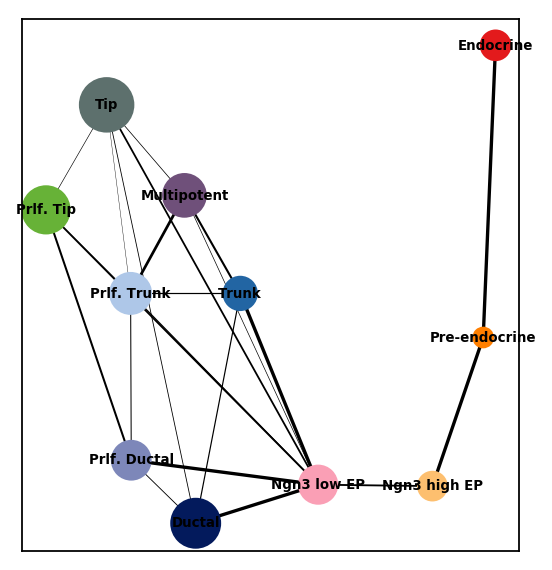

computing UMAP
    finished (0:00:28.63) --> added
    'X_umap', UMAP coordinates (adata.obsm)


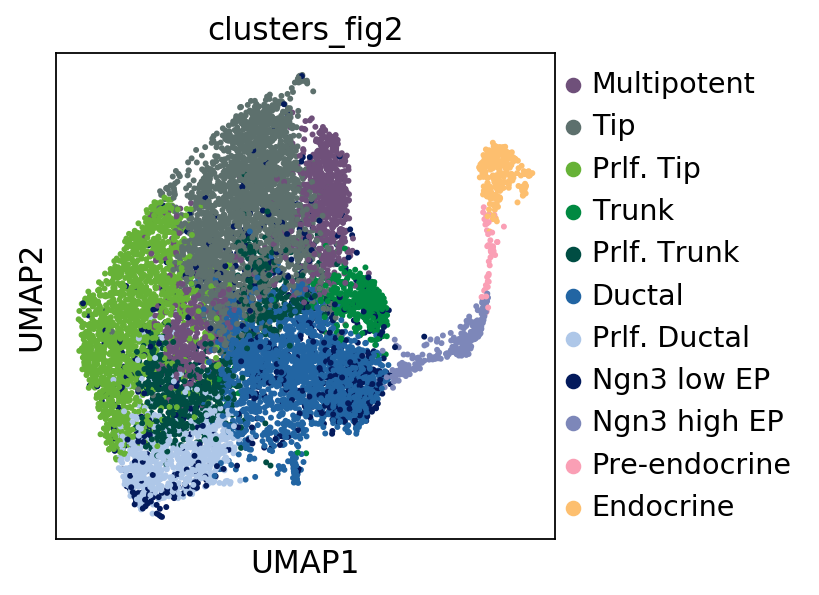

computing neighbors
    finished (0:00:46.36) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:25.67) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:26.64) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Number of obtained velocity_genes: 938
computing velocity graph
    finished (0:01:38.00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:08.41) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 320x320 with 0 Axes>

In [192]:
adata_velo_12=adata_all_velo_sub[np.isin(adata_new_hvg_sub.obs['day'],'12.5')].copy()
adata_hvg_12=adata_new_hvg_sub[np.isin(adata_new_hvg_sub.obs['day'],'12.5')].copy()
sc.pp.pca(adata_hvg_12)
sc.pp.neighbors(adata_hvg_12)
adata_velo_12.uns['clusters_fig3_final_colors']=adata_new.uns['clusters_fig3_final_colors']
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True)
sc.tl.paga(adata_hvg_12,groups='clusters_fig3_final')
pos=np.array([[-3.276080093 , -1.2],#mpc
       [-5.1822512769, 0],#tip
       [-6.6674343885, -1.39223995  ],#prlf tip
       [-1.9095328425, -2.5],#trunk
       [-4.5944196209, -2.5],#prlf trunk
       [-3, -5.5473209737],#duct
       [-4.5787940696, -4.7118794041],#prlf.duct
       [0, -5.0359884718],#early ep
       [ 2.7994142546, -5.0550800284],#ep
       [4.0438095194, -3.0846208514],#pre-endo
       [4.3462040595,  0.7894487691]])#,#endo
sc.pl.paga(adata_hvg_12,edge_width_scale=0.2,threshold=0.11,pos=pos,fontsize=6,node_size_scale=2)
sc.tl.umap(adata_hvg_12,init_pos='paga')
adata_velo_12.obsm['X_umap']=adata_hvg_12.obsm['X_umap']

sc.pl.umap(adata_velo_12,color='clusters_fig3_final')

adata_velo_12.uns['neighbors']=adata_hvg_12.uns['neighbors']
scv.pp.moments(adata_velo_12)
scv.tl.velocity(adata_velo_12,perc=95)
scv.tl.velocity_genes(adata_velo_12, min_r2=.1)
scv.tl.velocity_graph(adata_velo_12)
scv.tl.velocity_embedding(adata_velo_12, basis='umap')

## 13.5

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/icb/sophie.tritschler/miniconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:06.41) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running partition-based graph abstraction (PAGA)
    finished (0:00:00.55) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


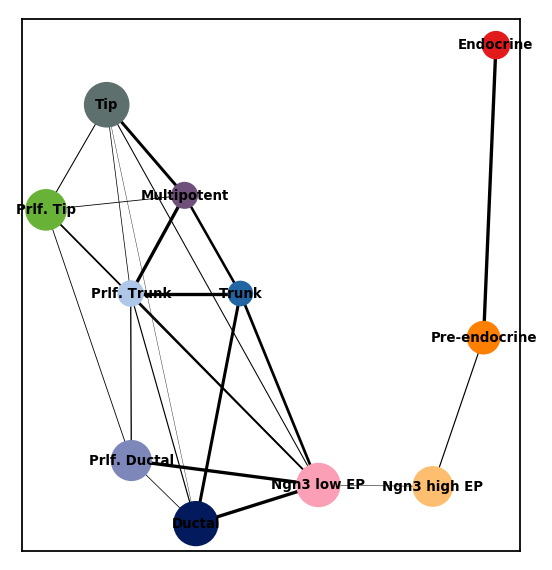

computing UMAP
    finished (0:00:31.72) --> added
    'X_umap', UMAP coordinates (adata.obsm)


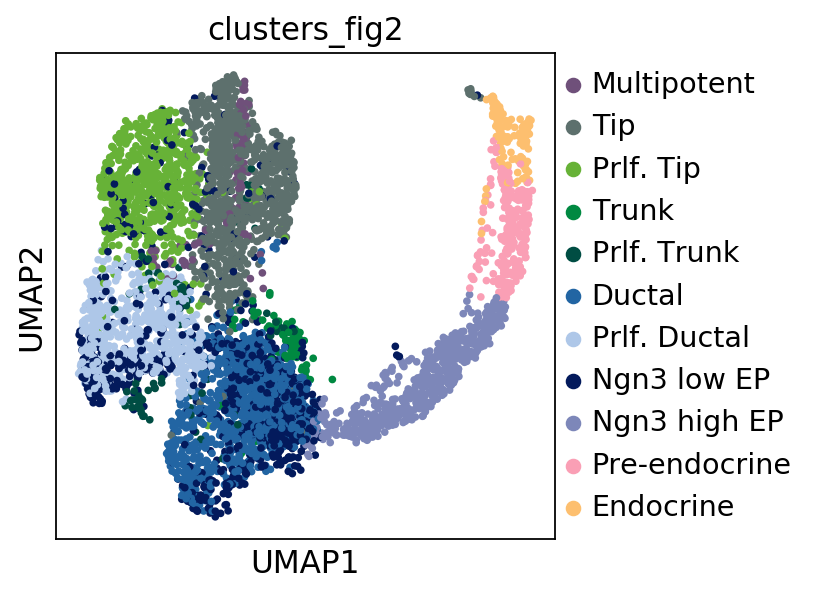

computing neighbors
    finished (0:00:26.10) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:13.05) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:10.32) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Number of obtained velocity_genes: 1638
computing velocity graph
    finished (0:02:18.61) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03.22) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 320x320 with 0 Axes>

In [195]:
adata_velo_13=adata_all_velo_sub[np.isin(adata_new_hvg_sub.obs['day'],'13.5')].copy()
adata_hvg_13=adata_new_hvg_sub[np.isin(adata_new_hvg_sub.obs['day'],'13.5')].copy()
sc.pp.pca(adata_hvg_13)
sc.pp.neighbors(adata_hvg_13)
adata_velo_13.uns['clusters_fig3_final_colors']=adata_new.uns['clusters_fig3_final_colors']
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True)
sc.tl.paga(adata_hvg_13,groups='clusters_fig3_final')
pos=np.array([[-3.276080093 , -1.2],#mpc
       [-5.1822512769, 0],#tip
       [-6.6674343885, -1.39223995  ],#prlf tip
       #[-3.5600819481,  1],#prlf acinar
       #[-1,  2],#mat acinar
       [-1.9095328425, -2.5],#trunk
       [-4.5944196209, -2.5],#prlf trunk
       [-3, -5.5473209737],#duct
       [-4.5787940696, -4.7118794041],#prlf.duct
       [0, -5.0359884718],#early ep
       [ 2.7994142546, -5.0550800284],#ep
       [4.0438095194, -3.0846208514],#pre-endo
       [4.3462040595,  0.7894487691]])#,#endo
sc.pl.paga(adata_hvg_13,edge_width_scale=0.2,threshold=0.11,pos=pos,fontsize=6,node_size_scale=2)
sc.tl.umap(adata_hvg_13,init_pos='paga')
adata_velo_13.obsm['X_umap']=adata_hvg_13.obsm['X_umap']

sc.pl.umap(adata_velo_13,color='clusters_fig3_final')

adata_velo_13.uns['neighbors']=adata_hvg_13.uns['neighbors']


scv.pp.moments(adata_velo_13)
scv.tl.velocity(adata_velo_13,perc=95)


scv.tl.velocity_genes(adata_velo_13, min_r2=.1)
scv.tl.velocity_graph(adata_velo_13)
scv.tl.velocity_embedding(adata_velo_13, basis='umap')


## 14.5

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/icb/sophie.tritschler/miniconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:12.24) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running partition-based graph abstraction (PAGA)
    finished (0:00:00.81) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


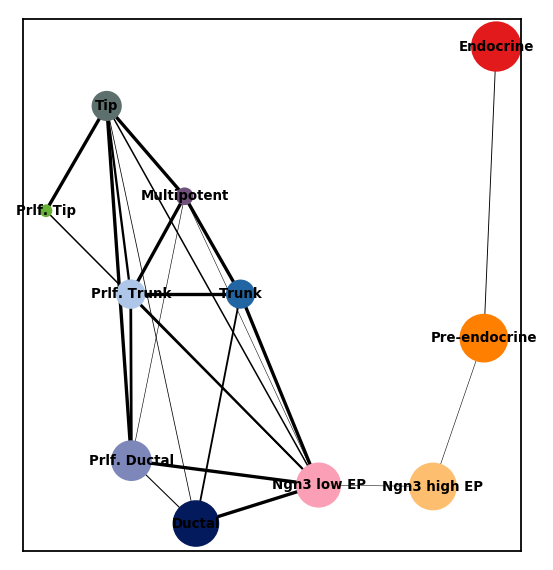

computing UMAP
    finished (0:00:43.01) --> added
    'X_umap', UMAP coordinates (adata.obsm)


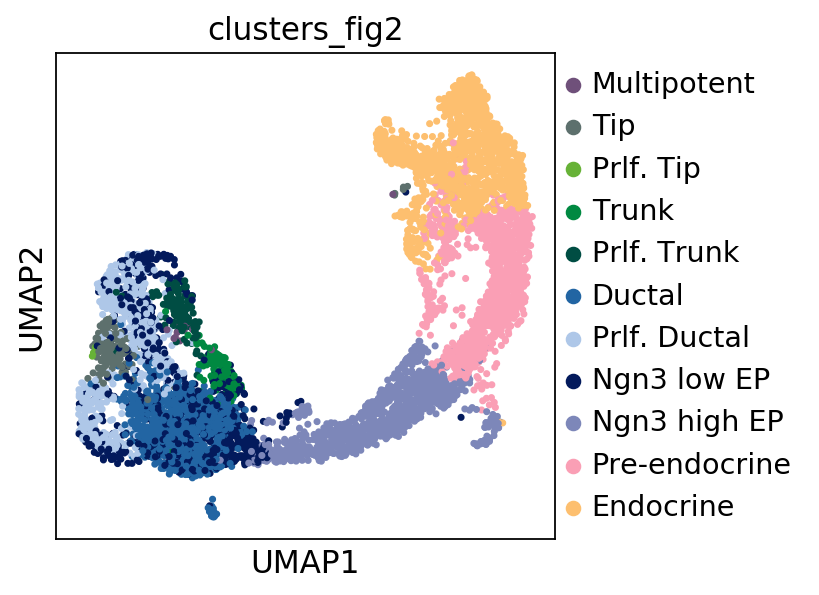

computing neighbors
    finished (0:00:35.23) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:17.41) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:13.94) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Number of obtained velocity_genes: 1765
computing velocity graph
    finished (0:03:25.15) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:04.90) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 320x320 with 0 Axes>

In [197]:
adata_velo_14=adata_all_velo_sub[np.isin(adata_new_hvg_sub.obs['day'],'14.5')].copy()
adata_hvg_14=adata_new_hvg_sub[np.isin(adata_new_hvg_sub.obs['day'],'14.5')].copy()
sc.pp.pca(adata_hvg_14)
sc.pp.neighbors(adata_hvg_14)
adata_velo_14.uns['clusters_fig3_final_colors']=adata_new.uns['clusters_fig3_final_colors']
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True)
sc.tl.paga(adata_hvg_14,groups='clusters_fig3_final')
pos=np.array([[-3.276080093 , -1.2],#mpc
       [-5.1822512769, 0],#tip
       [-6.6674343885, -1.39223995  ],#prlf tip
       #[-3.5600819481,  1],#prlf acinar
       #[-1,  2],#mat acinar
       [-1.9095328425, -2.5],#trunk
       [-4.5944196209, -2.5],#prlf trunk
       [-3, -5.5473209737],#duct
       [-4.5787940696, -4.7118794041],#prlf.duct
       [0, -5.0359884718],#early ep
       [ 2.7994142546, -5.0550800284],#ep
       [4.0438095194, -3.0846208514],#pre-endo
       [4.3462040595,  0.7894487691]])#,#endo
sc.pl.paga(adata_hvg_14,edge_width_scale=0.2,threshold=0.11,pos=pos,fontsize=6,node_size_scale=2)
sc.tl.umap(adata_hvg_14,init_pos='paga')
adata_velo_14.obsm['X_umap']=adata_hvg_14.obsm['X_umap']

sc.pl.umap(adata_velo_14,color='clusters_fig3_final')

adata_velo_14.uns['neighbors']=adata_hvg_14.uns['neighbors']


scv.pp.moments(adata_velo_14)
scv.tl.velocity(adata_velo_14,perc=95)


scv.tl.velocity_genes(adata_velo_14, min_r2=.1)
scv.tl.velocity_graph(adata_velo_14)
scv.tl.velocity_embedding(adata_velo_14, basis='umap')


## 15.5

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing neighbors
    using 'X_pca' with n_pcs = 50


/home/icb/sophie.tritschler/miniconda3/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


    finished (0:00:07.14) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
running partition-based graph abstraction (PAGA)
    finished (0:00:00.48) --> added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns)
--> added 'pos', the PAGA positions (adata.uns['paga'])


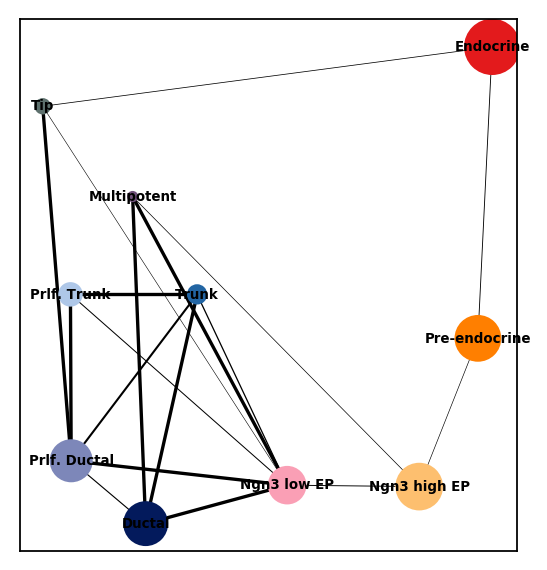

computing UMAP
    finished (0:00:25.96) --> added
    'X_umap', UMAP coordinates (adata.obsm)


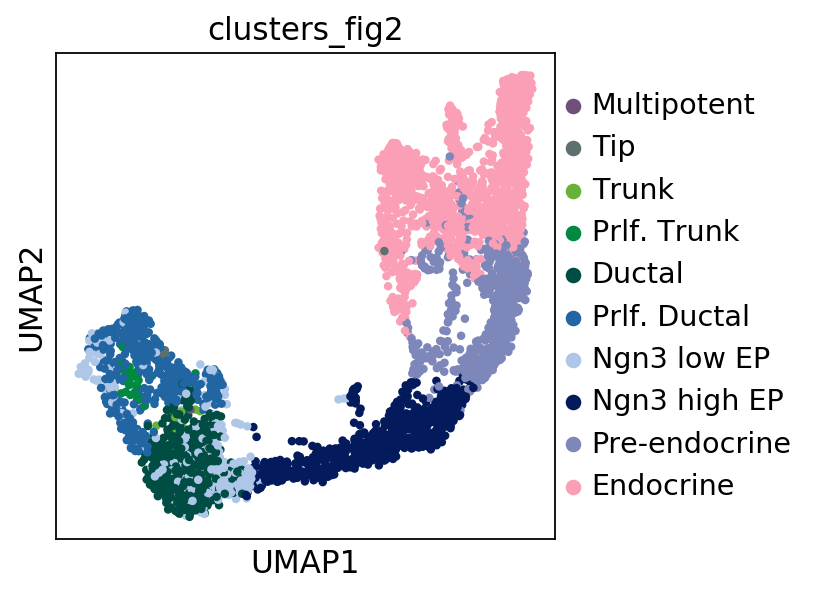

computing neighbors
    finished (0:00:17.78) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing moments based on connectivities
    finished (0:00:09.53) --> added 
    'Ms' and 'Mu', moments of spliced/unspliced abundances (adata.layers)
computing velocities
    finished (0:00:08.10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
Number of obtained velocity_genes: 1648
computing velocity graph
    finished (0:01:33.72) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02.95) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<Figure size 320x320 with 0 Axes>

In [199]:
adata_velo_15=adata_all_velo_sub[np.isin(adata_new_hvg_sub.obs['day'],'15.5')].copy()
adata_hvg_15=adata_new_hvg_sub[np.isin(adata_new_hvg_sub.obs['day'],'15.5')].copy()
sc.pp.pca(adata_hvg_15)
sc.pp.neighbors(adata_hvg_15)
adata_velo_15.uns['clusters_fig3_final_colors']=adata_new.uns['clusters_fig3_final_colors']
sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=300,transparent=True)
sc.tl.paga(adata_hvg_15,groups='clusters_fig3_final')
pos=np.array([[-3.276080093 , -1.2],#mpc
       [-5.1822512769, 0],#tip
       [-1.9095328425, -2.5],#trunk
       [-4.5944196209, -2.5],#prlf trunk
       [-3, -5.5473209737],#duct
       [-4.5787940696, -4.7118794041],#prlf.duct
       [0, -5.0359884718],#early ep
       [ 2.7994142546, -5.0550800284],#ep
       [4.0438095194, -3.0846208514],#pre-endo
       [4.3462040595,  0.7894487691]])#,#endo
sc.pl.paga(adata_hvg_15,edge_width_scale=0.2,threshold=0.11,pos=pos,fontsize=6,node_size_scale=2)
sc.tl.umap(adata_hvg_15,init_pos='paga')
adata_velo_15.obsm['X_umap']=adata_hvg_15.obsm['X_umap']

sc.pl.umap(adata_velo_15,color='clusters_fig3_final')

adata_velo_15.uns['neighbors']=adata_hvg_15.uns['neighbors']


scv.pp.moments(adata_velo_15)
scv.tl.velocity(adata_velo_15,perc=95)


scv.tl.velocity_genes(adata_velo_15, min_r2=.1)
scv.tl.velocity_graph(adata_velo_15)
scv.tl.velocity_embedding(adata_velo_15, basis='umap')


## Velocity plots - Figure 6B

In [252]:
# adata_velo_12.uns['clusters_fig4_colors']=['#6F507A', '#5D706D', '#67B237','#2265A3',
#        '#aec7e8', '#031A5C', '#7d87b9', '#fa9fb5', '#fdbf6f', '#ff7f00',
#        '#b2df8a', '#1f78b4', '#6a3d9a', '#cab2d6']
# adata_velo_13.uns['clusters_fig4_colors']=['#6F507A', '#5D706D', '#67B237','#2265A3',
#        '#aec7e8', '#031A5C', '#7d87b9', '#fa9fb5', '#fdbf6f', '#ff7f00',
#        '#b2df8a', '#1f78b4', '#6a3d9a', '#cab2d6']
# adata_velo_14.uns['clusters_fig4_colors']=['#6F507A', '#5D706D', '#67B237','#2265A3',
#        '#aec7e8', '#031A5C', '#7d87b9', '#fa9fb5', '#fdbf6f', '#ff7f00',
#        '#b2df8a', '#1f78b4', '#6a3d9a', '#cab2d6']
# adata_velo_15.uns['clusters_fig4_colors']=['#6F507A', '#5D706D','#2265A3',
#        '#aec7e8', '#031A5C', '#7d87b9', '#fa9fb5', '#fdbf6f', '#ff7f00',
#        '#b2df8a', '#1f78b4', '#6a3d9a', '#cab2d6']

In [389]:
## merge tip, trunk and ductal clusters

ref_clust=pd.Categorical(adata_velo_12.obs['clusters_fig6_broad_final'],categories=[
    'Multipotent', 'Tip', 'Prlf. Tip', 'Trunk', 'Prlf. Trunk', 'Ductal',
    'Prlf. Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta',
    'Alpha', 'Delta', 'Epsilon'])

ref_clust[ref_clust=='Prlf. Tip']='Tip'
ref_clust[ref_clust=='Prlf. Trunk']='Trunk'
ref_clust[ref_clust=='Prlf. Ductal']='Ductal'

adata_velo_12.obs['clusters_fig6_velo_final']=pd.Categorical(ref_clust,categories=[
    'Multipotent', 'Tip','Trunk','Ductal','Ngn3 low EP', 
    'Ngn3 high EP', 'Pre-endocrine', 'Beta',
    'Alpha', 'Delta', 'Epsilon'])

In [411]:
velo_colors=['#67000d',
 '#5D706D',
 '#aec7e8',
 '#031A5C',
 '#fa9fb5',
 '#fdbf6f',
 '#ff7f00',
 '#b2df8a',
 '#1f78b4',
 '#6a3d9a',
 '#cab2d6']

In [412]:
adata_velo_12.uns['clusters_fig6_velo_final_colors']=velo_colors

In [414]:
adata_hvg_12.obs['clusters_fig6_velo_final']=adata_velo_12.obs['clusters_fig6_velo_final']
adata_hvg_12.uns['clusters_fig6_velo_final_colors']=adata_velo_12.uns['clusters_fig6_velo_final_colors']

In [459]:
pos=np.array([[-1.70155702, -1.33280238],
       [-5.85760488, 0.86210562],
       [-4.43046822, -3.365352  ],
       [-4.09654371, -4.94195022],
       [-1.01876662, -4.48833005],#ep low
       [ 4.88291495, -3.76627961],
       [ 6.19581412, -0.59367356],
       [ 6.29355023,  0.99392237],
       [ 6.69806933,  1.67162501],
       [ 6.52319975,  1.46472733],
       [ 5.88821224,  1.76904865]])

In [ ]:
sc.tl.paga(adata_hvg_12,groups='clusters_fig6_velo_final')

--> added 'pos', the PAGA positions (adata.uns['paga'])


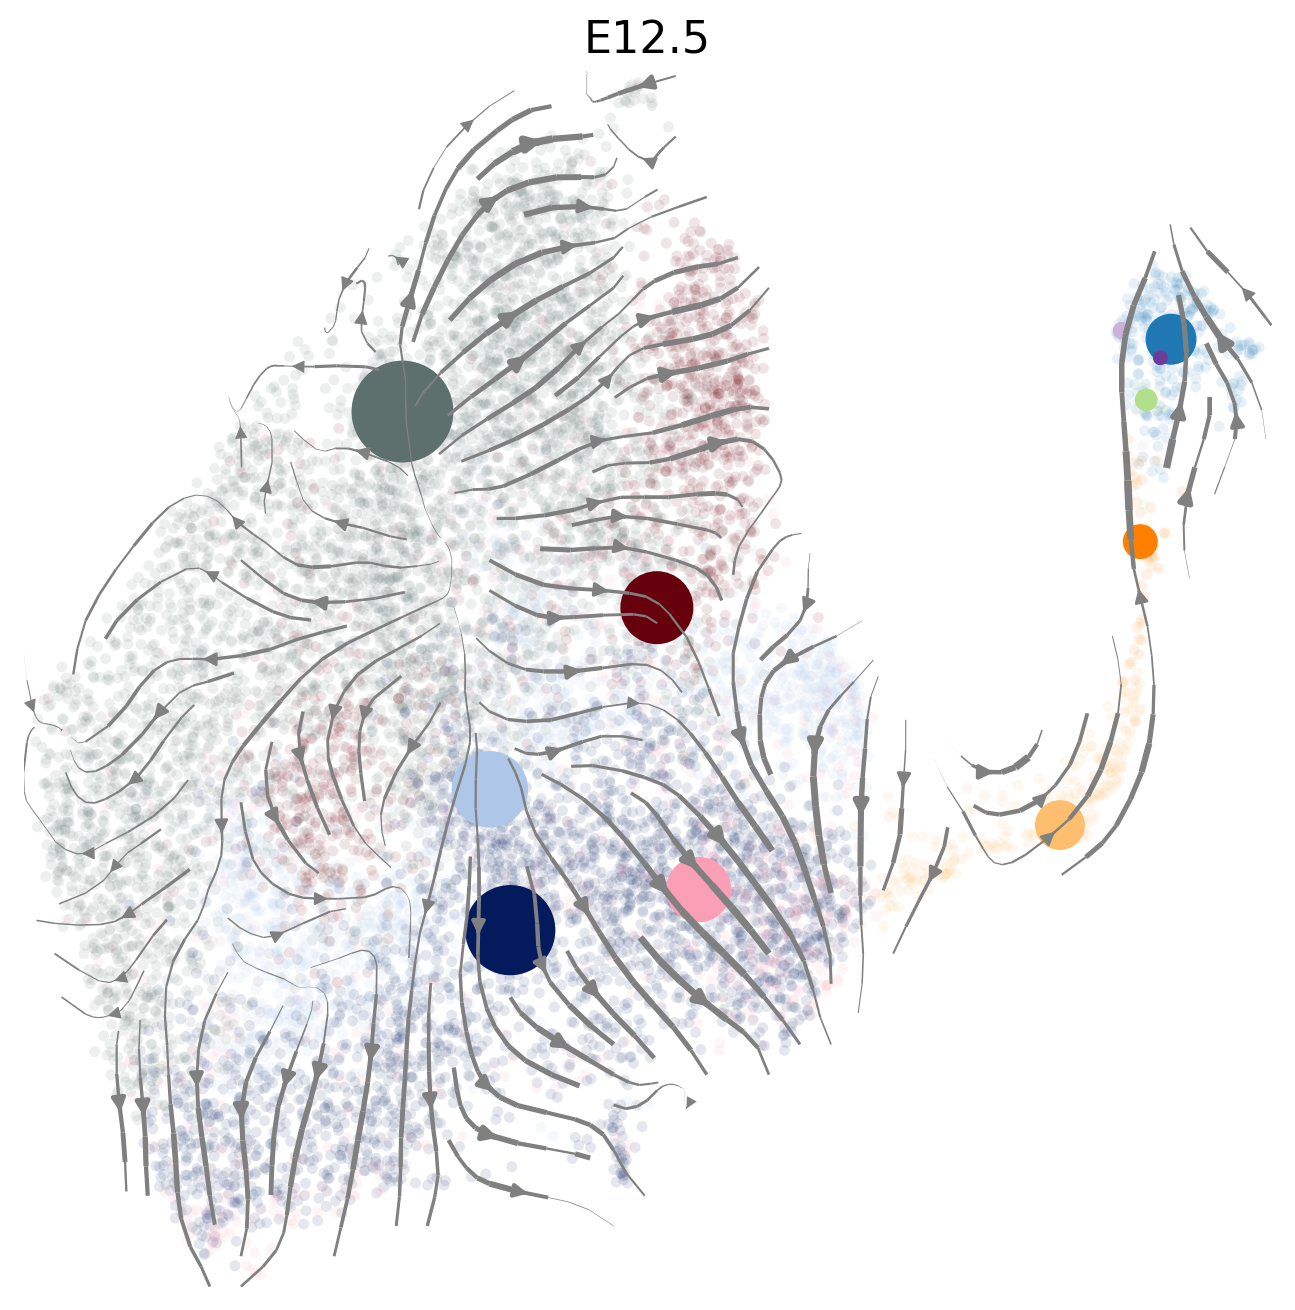

In [460]:
scv.settings.set_figure_params(figsize=(8,8))
fig1, ax1 = pl.subplots()
scv.pl.velocity_embedding_stream(adata_velo_12, basis='umap',color='clusters_fig6_velo_final',ax=ax1,show=False,linewidth=1.5,
                                 legend_loc='upper right',
                                 title='E12.5',density=0.7)

sc.pl.paga(adata_hvg_12, pos=pos, show=False, node_size_scale=2,frameon=False,ax=ax1,
           edge_width_scale=0.1,threshold=2,text_kwds={'alpha':0})

ax1.get_legend().remove()
ax1.set_title('E12.5',fontdict={'fontsize':16})
pl.savefig('./umap_velocity_12.png')

pl.show()

In [433]:
velo_colors=['#67000d',
 '#5D706D',
 '#aec7e8',
 '#031A5C',
 '#fa9fb5',
 '#fdbf6f',
 '#ff7f00',
 '#b2df8a',
 '#1f78b4',
 '#cab2d6']

In [434]:
ref_clust=pd.Categorical(adata_velo_13.obs['clusters_fig6_broad_final'],categories=[
    'Multipotent', 'Tip', 'Prlf. Tip', 'Trunk', 'Prlf. Trunk', 'Ductal',
    'Prlf. Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta',
    'Alpha', 'Delta', 'Epsilon'])


ref_clust[ref_clust=='Prlf. Tip']='Tip'
ref_clust[ref_clust=='Prlf. Trunk']='Trunk'
ref_clust[ref_clust=='Prlf. Ductal']='Ductal'

adata_velo_13.obs['clusters_fig6_velo_final']=pd.Categorical(ref_clust,categories=[
    'Multipotent', 'Tip','Trunk','Ductal',
    'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 
    'Beta','Alpha','Epsilon'])

adata_velo_13.uns['clusters_fig6_velo_final_colors']=velo_colors
adata_hvg_13.obs['clusters_fig6_velo_final']=adata_velo_13.obs['clusters_fig6_velo_final']
adata_hvg_13.uns['clusters_fig6_velo_final_colors']=adata_velo_13.uns['clusters_fig6_velo_final_colors']

In [464]:
pos=np.array([[-4.31694992, 0.98062669],
       [-6.63577144, -0.60032631],
       [-3.65384914, -4.26137315],
       [-6.06746045, -5.90612232],
       [-1.57457266, -7.16074136],#ep low
       [ 4.60860991, -6.11448844],
       [ 8.59291816, -1.81091805],
       [ 9.38935033,  0.59999307],
       [ 8.10031811,  1.10680471],
       [ 7.44161595, -1.09547866]])

In [ ]:
sc.tl.paga(adata_hvg_13,groups='clusters_fig6_velo_final')

--> added 'pos', the PAGA positions (adata.uns['paga'])


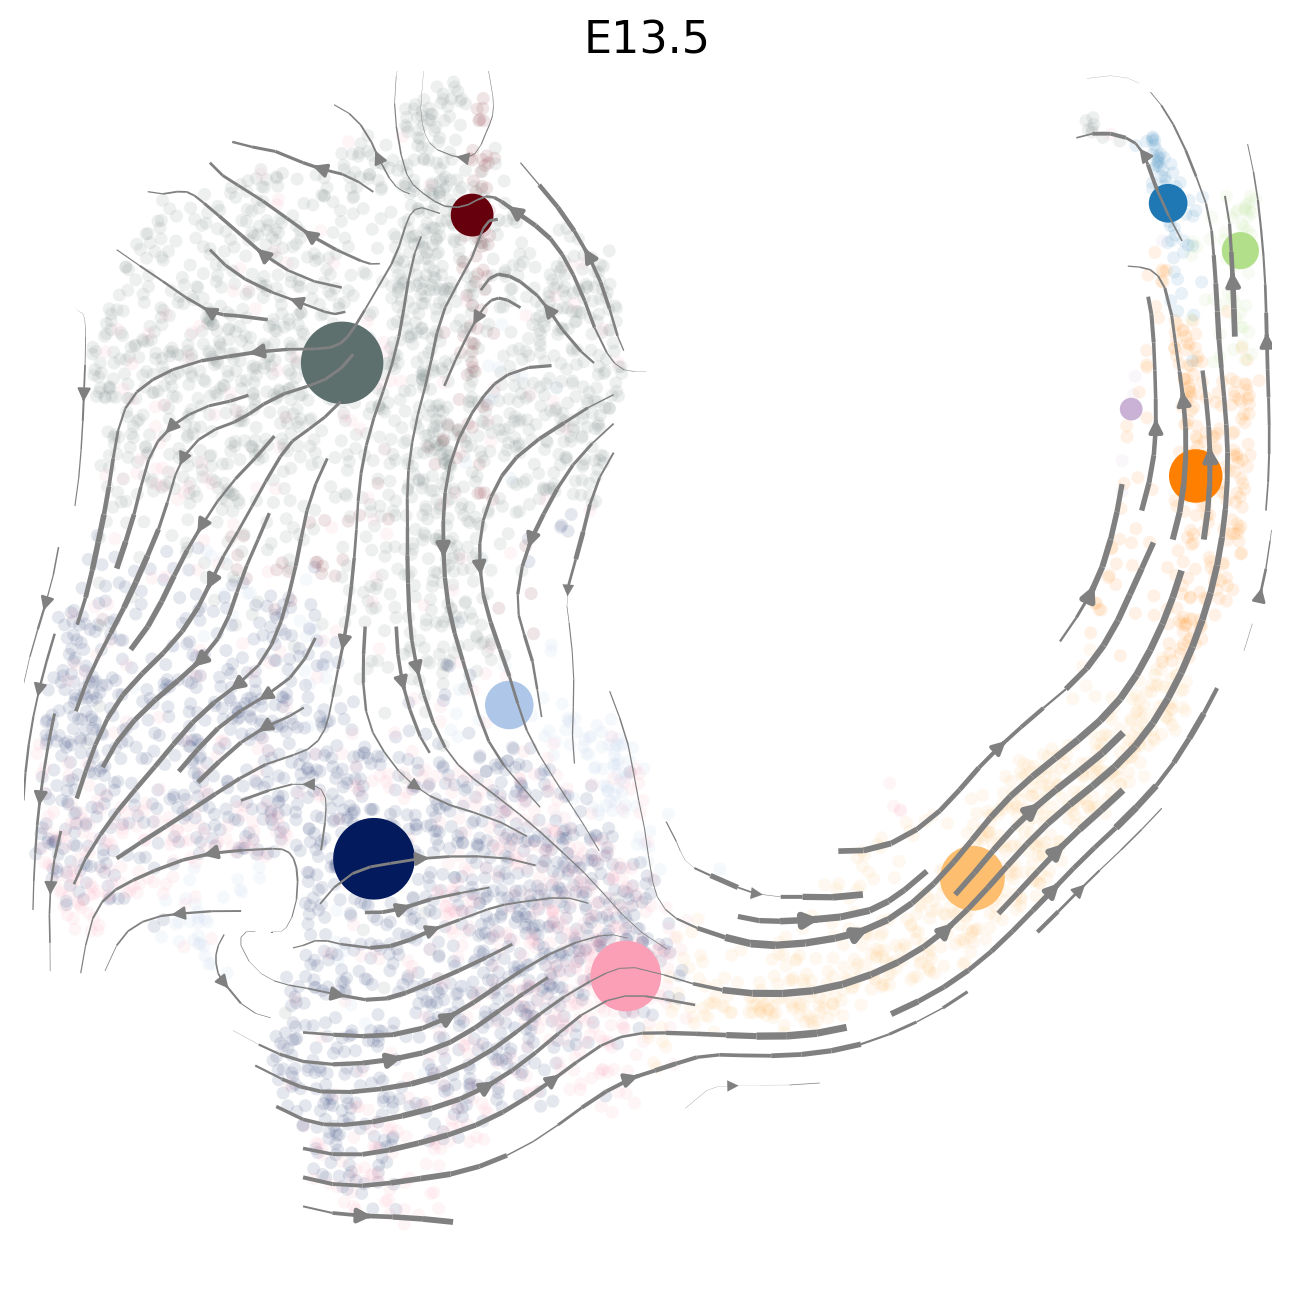

In [465]:
scv.settings.set_figure_params(figsize=(8,8))
fig1, ax1 = pl.subplots()
scv.pl.velocity_embedding_stream(adata_velo_13, basis='umap',color='clusters_fig6_velo_final',ax=ax1,show=False,linewidth=1.5,
                                 legend_loc='upper right',
                                 title='E13.5',density=0.7)


sc.pl.paga(adata_hvg_13, pos=pos, show=False, node_size_scale=2,frameon=False,ax=ax1,
           edge_width_scale=0.1,threshold=2,text_kwds={'alpha':0})

ax1.get_legend().remove()
ax1.set_title('E13.5',fontdict={'fontsize':16})
pl.savefig('./umap_velocity_13.png')

pl.show()


In [437]:
ref_clust=pd.Categorical(adata_velo_14.obs['clusters_fig6_broad_final'],categories=[
    'Multipotent', 'Tip', 'Prlf. Tip', 'Trunk', 'Prlf. Trunk', 'Ductal',
    'Prlf. Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 'Beta',
    'Alpha', 'Delta', 'Epsilon'])

ref_clust[ref_clust=='Prlf. Tip']='Tip'
ref_clust[ref_clust=='Prlf. Trunk']='Trunk'
ref_clust[ref_clust=='Prlf. Ductal']='Ductal'

adata_velo_14.obs['clusters_fig6_velo_final']=pd.Categorical(ref_clust,categories=[
    'Multipotent', 'Tip','Trunk','Ductal',
    'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 
    'Beta','Alpha','Delta','Epsilon'])

adata_velo_14.uns['clusters_fig6_velo_final_colors']=velo_colors
adata_hvg_14.obs['clusters_fig6_velo_final']=adata_velo_14.obs['clusters_fig6_velo_final']
adata_hvg_14.uns['clusters_fig6_velo_final_colors']=adata_velo_14.uns['clusters_fig6_velo_final_colors']

In [ ]:
sc.tl.paga(adata_hvg_14,groups='clusters_fig6_velo_final')

In [466]:
pos=np.array([[-6.2429803, -4.42509146],
       [-9.51683848, -5.17551645],
       [-5.45202234, -4.89028095],
       [-6.91410508, -7.99379249],
       [-4.33589748, -8.26188533],#ep low
       [ 3.45308213, -7.89885248],
       [ 7.9543333 , -2.34044398],
       [ 5.70901527,  2.33098172],
       [ 7.37993865,  3.65705307],
       [ 4.10962145,  0.3872786 ],
       [ 4.37356456, -0.65680124]])

--> added 'pos', the PAGA positions (adata.uns['paga'])


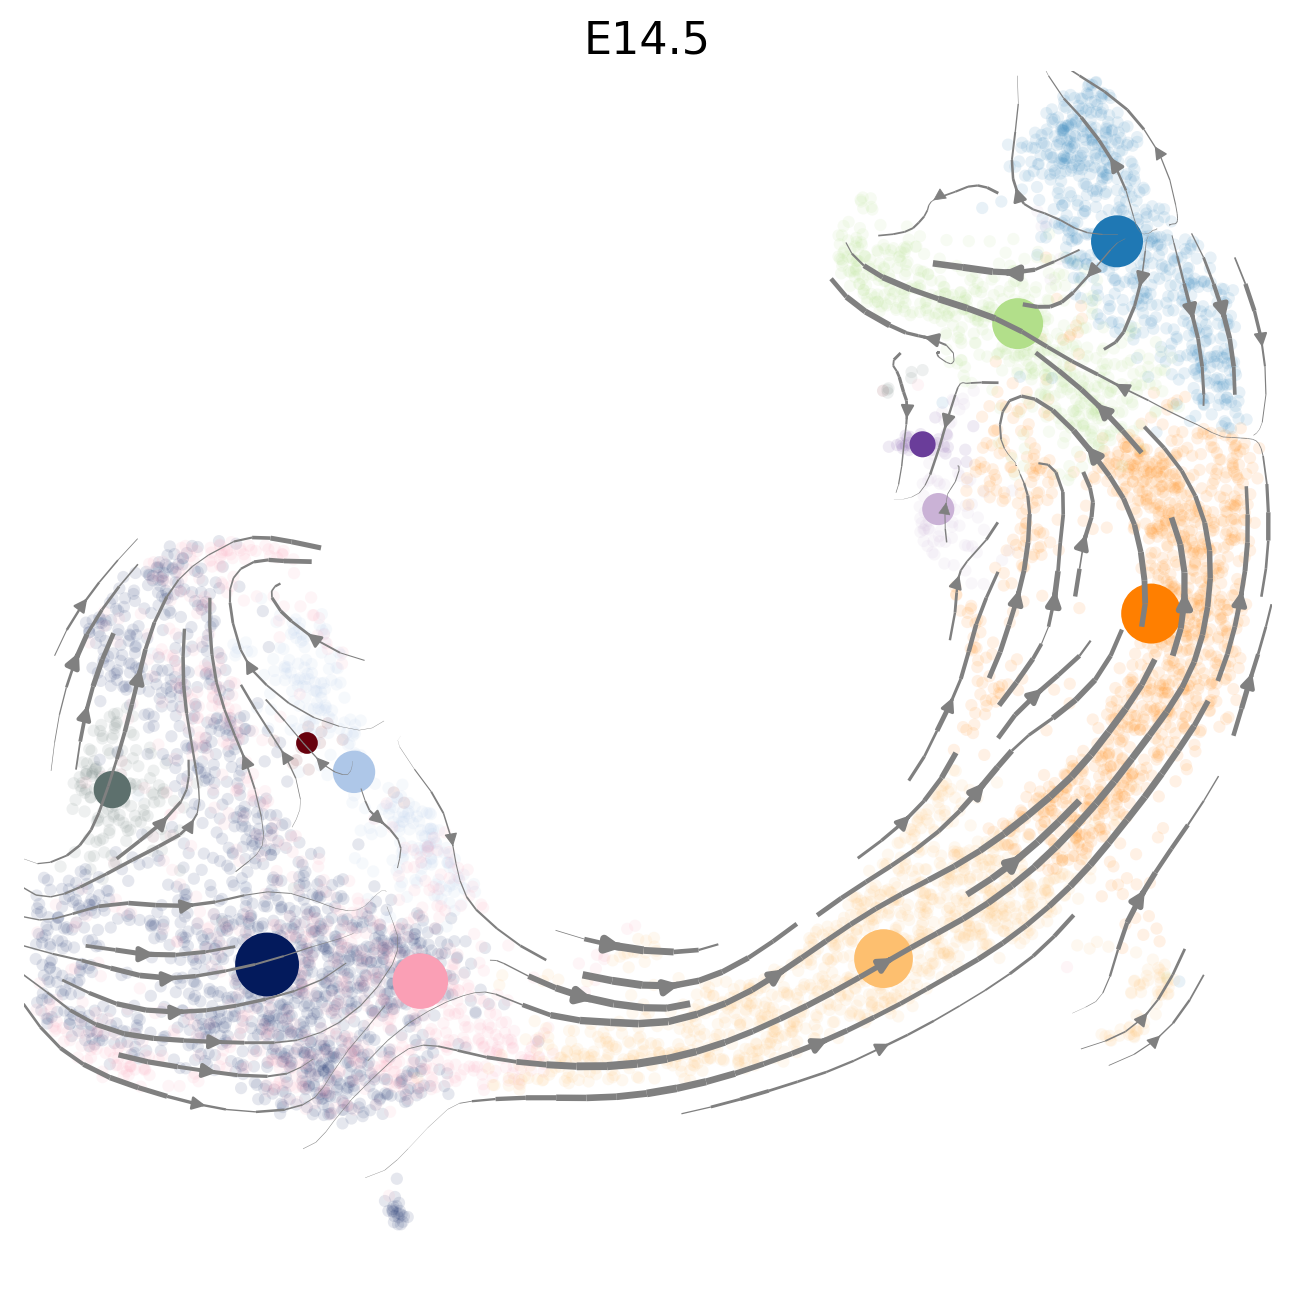

In [467]:
scv.settings.set_figure_params(figsize=(8,8))
fig1, ax1 = pl.subplots()
scv.pl.velocity_embedding_stream(adata_velo_14, basis='umap',color='clusters_fig6_velo_final',ax=ax1,show=False,linewidth=1.5,
                                 legend_loc='upper right',
                                 title='E14.5',density=0.7)

sc.pl.paga(adata_hvg_14, pos=pos, show=False, node_size_scale=2,frameon=False,ax=ax1,
           edge_width_scale=0.1,threshold=2,text_kwds={'alpha':0})

ax1.get_legend().remove()
ax1.set_title('E14.5',fontdict={'fontsize':16})
pl.savefig('./umap_velocity_14.png')

pl.show()


In [454]:
ref_clust=pd.Categorical(adata_velo_15.obs['clusters_fig6_broad_final'],categories=[
    'Multipotent', 'Tip', 'Prlf. Tip', 'Trunk', 'Prlf. Trunk', 'Ductal',
    'Prlf. Ductal', 'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 
    'Beta','Alpha', 'Delta', 'Epsilon'])

ref_clust[ref_clust=='Prlf. Tip']='Tip'
ref_clust[ref_clust=='Prlf. Trunk']='Trunk'
ref_clust[ref_clust=='Prlf. Ductal']='Ductal'

adata_velo_15.obs['clusters_fig6_velo_final']=pd.Categorical(ref_clust,categories=[
    'Multipotent', 'Tip','Trunk','Ductal',
    'Ngn3 low EP', 'Ngn3 high EP', 'Pre-endocrine', 
    'Beta','Alpha','Delta','Epsilon'])

adata_velo_15.uns['clusters_fig6_velo_final_colors']=velo_colors
adata_hvg_15.obs['clusters_fig6_velo_final']=adata_velo_15.obs['clusters_fig6_velo_final']
adata_hvg_15.uns['clusters_fig6_velo_final_colors']=adata_velo_15.uns['clusters_fig6_velo_final_colors']

In [468]:
pos=np.array([[-2.88537801, -4.44074567],
       [-3.09960345, -4.85993543],
       [-5.95758332, -4.35216256],
       [-3.23138251, -3.31986013],
       [-0.0882511, -3.21898322],#ep low
       [ 6.77956975, -4.53491469],
       [11.33498054,  0.26129883],
       [ 9.56004144,  5.66489165],
       [12.81135456,  6.53406079],
       [ 7.46455924,  2.60289707],
       [14.80703749,  4.42749855]])

In [ ]:
sc.tl.paga(adata_hvg_15,groups='clusters_fig6_velo_final')

--> added 'pos', the PAGA positions (adata.uns['paga'])


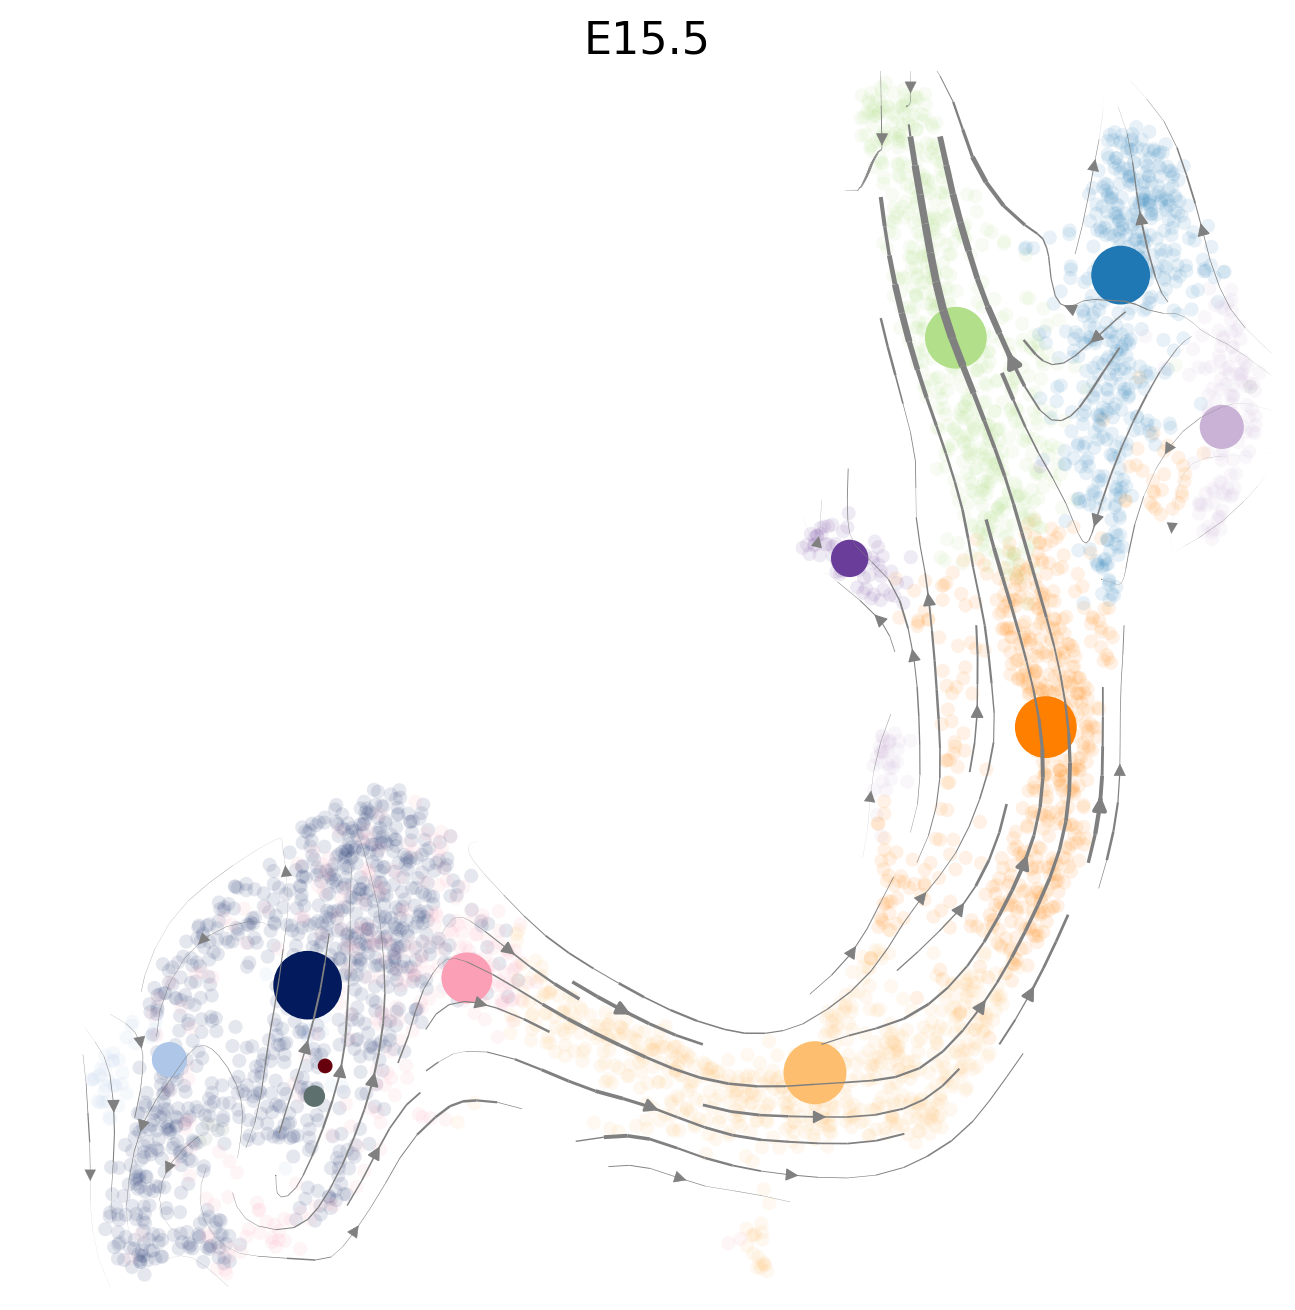

In [469]:
scv.settings.set_figure_params(figsize=(8,8))
fig1, ax1 = pl.subplots()
scv.pl.velocity_embedding_stream(adata_velo_15, basis='umap',color='clusters_fig6_velo_final',ax=ax1,show=False,linewidth=1.5,
                                 legend_loc='upper right',
                                 title='E15.5',density=0.7)

sc.pl.paga(adata_hvg_15, pos=pos, show=False, node_size_scale=2,frameon=False,ax=ax1,
           edge_width_scale=0.1,threshold=2,text_kwds={'alpha':0})

ax1.get_legend().remove()
ax1.set_title('E15.5',fontdict={'fontsize':16})
pl.savefig('./umap_velocity_15.png')
pl.show()

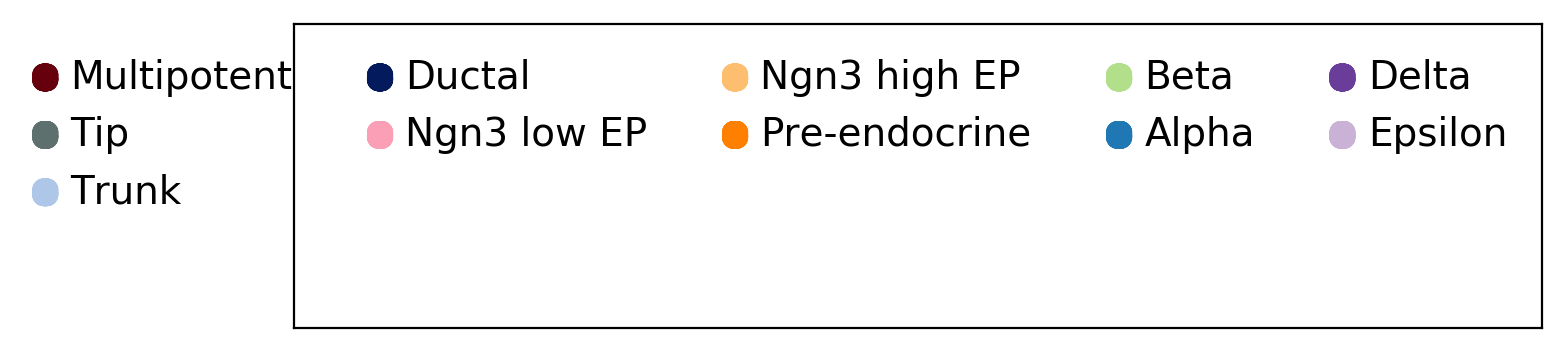

In [525]:
scv.settings.set_figure_params(figsize=(8,2))

labels=adata_hvg_15.obs['clusters_fig6_velo_final'].cat.categories
for i,area in enumerate([50, 50, 50,50,50,50,50,50,50,50,50]):
    pl.scatter([], [], c=velo_colors[i], alpha=1, s=area,
                label=labels[i])
    

pl.legend(scatterpoints=100, frameon=False, labelspacing=0.5, title='',ncol=5,fontsize=14)
pl.yticks([])
pl.xticks([])

pl.savefig('./velocity_legend.pdf')
